# 제품 이상여부 판별 프로젝트


## 1. 데이터 불러오기


### 필수 라이브러리


In [160]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm

### 데이터 읽어오기


In [161]:
ROOT_DIR = "data"
RANDOM_STATE = 110

# Load data
train_data = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))
train_data

,Wip Line_Dam,Process Desc._Dam,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,Insp. Seq No._Dam,Insp Judge Code_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION X Unit Time_Dam,CURE END POSITION X Judge Value_Dam,...,Production Qty Collect Result_Fill2,Production Qty Unit Time_Fill2,Production Qty Judge Value_Fill2,Receip No Collect Result_Fill2,Receip No Unit Time_Fill2,Receip No Judge Value_Fill2,WorkMode Collect Result_Fill2,WorkMode Unit Time_Fill2,WorkMode Judge Value_Fill2,target
0,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,4F1XA938-1,1,OK,240.0,NaN,NaN,...,7,NaN,NaN,127,NaN,NaN,1,NaN,NaN,Normal
1,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,3KPM0016-2,1,OK,240.0,NaN,NaN,...,185,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal
2,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4E1X9167-1,1,OK,1000.0,NaN,NaN,...,10,NaN,NaN,73,NaN,NaN,1,NaN,NaN,Normal
3,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3K1X0057-1,1,OK,1000.0,NaN,NaN,...,268,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal
4,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3HPM0007-1,1,OK,240.0,NaN,NaN,...,121,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3J1XF434-2,1,OK,240.0,NaN,NaN,...,318,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal
40502,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4E1XC796-1,1,OK,1000.0,NaN,NaN,...,14,NaN,NaN,197,NaN,NaN,1,NaN,NaN,Normal
40503,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,4C1XD438-1,1,OK,240.0,NaN,NaN,...,1,NaN,NaN,27,NaN,NaN,1,NaN,NaN,Normal
40504,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3I1XA258-1,1,OK,1000.0,NaN,NaN,...,117,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal


## 2. 전처리

결측치 확인, 제거

In [162]:
# 결측치가 있는 컬럼들만 추출하고 결측치 개수 계산
missing_data = train_data.isnull().sum()
missing_columns = missing_data[missing_data > 0]

# 결과 출력
print("결측치가 있는 컬럼들:")
print(missing_columns)

결측치가 있는 컬럼들:
CURE END POSITION X Unit Time_Dam      40506
CURE END POSITION X Judge Value_Dam    40506
CURE END POSITION Z Unit Time_Dam      40506
CURE END POSITION Z Judge Value_Dam    40506
CURE END POSITION Θ Unit Time_Dam      40506
                                       ...  
Production Qty Judge Value_Fill2       40506
Receip No Unit Time_Fill2              40506
Receip No Judge Value_Fill2            40506
WorkMode Unit Time_Fill2               40506
WorkMode Judge Value_Fill2             40506
Length: 286, dtype: int64


In [163]:
# 결측치가 40506개인 열들을 찾고 제거
cols_to_drop = train_data.columns[train_data.isnull().sum() == 40506]
train_data_cleaned = train_data.drop(columns=cols_to_drop)

# 결과 출력
print(f"제거된 컬럼들: {cols_to_drop.tolist()}")
print(f"남은 컬럼들: {train_data_cleaned}")

# null값만 있는 열을 제외하면 186개의 컬럼

제거된 컬럼들: ['CURE END POSITION X Unit Time_Dam', 'CURE END POSITION X Judge Value_Dam', 'CURE END POSITION Z Unit Time_Dam', 'CURE END POSITION Z Judge Value_Dam', 'CURE END POSITION Θ Unit Time_Dam', 'CURE END POSITION Θ Judge Value_Dam', 'CURE SPEED Unit Time_Dam', 'CURE SPEED Judge Value_Dam', 'CURE STANDBY POSITION X Unit Time_Dam', 'CURE STANDBY POSITION X Judge Value_Dam', 'CURE STANDBY POSITION Z Unit Time_Dam', 'CURE STANDBY POSITION Z Judge Value_Dam', 'CURE STANDBY POSITION Θ Unit Time_Dam', 'CURE STANDBY POSITION Θ Judge Value_Dam', 'CURE START POSITION X Unit Time_Dam', 'CURE START POSITION X Judge Value_Dam', 'CURE START POSITION Z Unit Time_Dam', 'CURE START POSITION Z Judge Value_Dam', 'CURE START POSITION Θ Unit Time_Dam', 'CURE START POSITION Θ Judge Value_Dam', 'DISCHARGED SPEED OF RESIN Unit Time_Dam', 'DISCHARGED SPEED OF RESIN Judge Value_Dam', 'DISCHARGED TIME OF RESIN(Stage1) Unit Time_Dam', 'DISCHARGED TIME OF RESIN(Stage1) Judge Value_Dam', 'DISCHARGED TIME OF RE

In [164]:
# 남은 결측치가 있는 컬럼들을 추출하고 결측치 개수 계산
missing_data = train_data_cleaned.isnull().sum()
missing_columns = missing_data[missing_data > 0]

# 결과 출력
print("결측치가 있는 컬럼들:")
print(missing_columns)

결측치가 있는 컬럼들:
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam      12766
HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam         29213
GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave          29213
GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave             29213
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1    12766
HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1       29213
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2    12766
HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2       29213
dtype: int64


object형 컬럼

In [165]:
# 데이터 형식이 object인 컬럼들만 추출
object_columns = train_data_cleaned.select_dtypes(include=['object'])

# 결과 출력
print("데이터 형식이 object인 컬럼들:")
object_columns

### 중간에 null 값과 숫자와 ok라고 쓰인 값들이 섞여 있는 컬럼이 존재

데이터 형식이 object인 컬럼들:


,Wip Line_Dam,Process Desc._Dam,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,Insp Judge Code_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam,Wip Line_AutoClave,Process Desc._AutoClave,...,HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1,Wip Line_Fill2,Process Desc._Fill2,Equipment_Fill2,Model.Suffix_Fill2,Workorder_Fill2,Insp Judge Code_Fill2,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2,HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2,target
0,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,4F1XA938-1,OK,NaN,NaN,IVI-OB6,Auto Clave Out,...,NaN,IVI-OB6,Fill2 Dispenser,Fill2 dispenser #1,AJX75334505,4F1XA938-1,OK,NaN,NaN,Normal
1,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,3KPM0016-2,OK,550.3,NaN,IVI-OB6,Auto Clave Out,...,NaN,IVI-OB6,Fill2 Dispenser,Fill2 dispenser #1,AJX75334505,3KPM0016-2,OK,835.5,NaN,Normal
2,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4E1X9167-1,OK,OK,OK,IVI-OB6,Auto Clave Out,...,OK,IVI-OB6,Fill2 Dispenser,Fill2 dispenser #2,AJX75334501,4E1X9167-1,OK,OK,OK,Normal
3,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3K1X0057-1,OK,162.4,NaN,IVI-OB6,Auto Clave Out,...,NaN,IVI-OB6,Fill2 Dispenser,Fill2 dispenser #2,AJX75334501,3K1X0057-1,OK,305,NaN,Normal
4,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3HPM0007-1,OK,549,NaN,IVI-OB6,Auto Clave Out,...,NaN,IVI-OB6,Fill2 Dispenser,Fill2 dispenser #1,AJX75334501,3HPM0007-1,OK,835.5,NaN,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3J1XF434-2,OK,550.3,NaN,IVI-OB6,Auto Clave Out,...,NaN,IVI-OB6,Fill2 Dispenser,Fill2 dispenser #1,AJX75334501,3J1XF434-2,OK,835.5,NaN,Normal
40502,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4E1XC796-1,OK,NaN,NaN,IVI-OB6,Auto Clave Out,...,NaN,IVI-OB6,Fill2 Dispenser,Fill2 dispenser #2,AJX75334501,4E1XC796-1,OK,NaN,NaN,Normal
40503,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,4C1XD438-1,OK,OK,OK,IVI-OB6,Auto Clave Out,...,OK,IVI-OB6,Fill2 Dispenser,Fill2 dispenser #1,AJX75334501,4C1XD438-1,OK,OK,OK,Normal
40504,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3I1XA258-1,OK,162.4,NaN,IVI-OB6,Auto Clave Out,...,NaN,IVI-OB6,Fill2 Dispenser,Fill2 dispenser #2,AJX75334501,3I1XA258-1,OK,305,NaN,Normal


HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam, Fill1, Fill2 컬럼 삭제

In [166]:
# 특정 열들의 이상치 처리
columns_to_replace = ['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
                      'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
                      'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2']

# 'OK' 값을 np.nan (null 값)으로 대체
train_data_cleaned[columns_to_replace] = train_data_cleaned[columns_to_replace].replace('OK', np.nan)

# 결과 확인
train_data_cleaned

,Wip Line_Dam,Process Desc._Dam,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,Insp. Seq No._Dam,Insp Judge Code_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,...,Head Clean Position Z Collect Result_Fill2,Head Purge Position X Collect Result_Fill2,Head Purge Position Y Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,target
0,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,4F1XA938-1,1,OK,240.0,2.5,-90,...,50.0,91.8,270,50,114.612,19.9,7,127,1,Normal
1,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,3KPM0016-2,1,OK,240.0,2.5,-90,...,91.8,270.0,50,85,19.600,7.0,185,1,0,Normal
2,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4E1X9167-1,1,OK,1000.0,12.5,90,...,50.0,91.8,270,50,114.612,19.8,10,73,1,Normal
3,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3K1X0057-1,1,OK,1000.0,12.5,90,...,91.8,270.0,50,85,19.900,12.0,268,1,0,Normal
4,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3HPM0007-1,1,OK,240.0,2.5,-90,...,91.8,270.0,50,85,19.700,8.0,121,1,0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3J1XF434-2,1,OK,240.0,2.5,-90,...,91.8,270.0,50,85,19.200,1.0,318,1,0,Normal
40502,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4E1XC796-1,1,OK,1000.0,12.5,90,...,50.0,91.8,270,50,114.612,20.5,14,197,1,Normal
40503,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,4C1XD438-1,1,OK,240.0,2.5,-90,...,50.0,91.8,270,50,85.000,19.7,1,27,1,Normal
40504,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3I1XA258-1,1,OK,1000.0,12.5,90,...,91.8,270.0,50,85,20.100,13.0,117,1,0,Normal


In [167]:
# 결측치 비율 계산 및 출력
for column in columns_to_replace:
    num_missing = train_data_cleaned[column].isnull().sum()

    # 전체 데이터 개수
    total = len(train_data_cleaned[column])

    # 결측치 비율
    missing_percentage = (num_missing / total) * 100

    # 결과 출력
    print(f"{column}의 결측치 비율: {missing_percentage:.2f}%")

HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam의 결측치 비율: 59.40%
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1의 결측치 비율: 59.40%
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2의 결측치 비율: 59.40%


In [168]:
# 결측치 비율이 50% 이상이므로 제거
columns_to_remove = [
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'
]

# 컬럼 제거
train_data_cleaned = train_data_cleaned.drop(columns=columns_to_remove)

액셀 data와 다른 컬럼 제거

In [169]:
# 잘못 유입된 컬럼 제거
train_data_cleaned = train_data_cleaned.drop(columns='GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave')
train_data_cleaned

,Wip Line_Dam,Process Desc._Dam,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,Insp. Seq No._Dam,Insp Judge Code_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,...,Head Clean Position Z Collect Result_Fill2,Head Purge Position X Collect Result_Fill2,Head Purge Position Y Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,target
0,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,4F1XA938-1,1,OK,240.0,2.5,-90,...,50.0,91.8,270,50,114.612,19.9,7,127,1,Normal
1,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,3KPM0016-2,1,OK,240.0,2.5,-90,...,91.8,270.0,50,85,19.600,7.0,185,1,0,Normal
2,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4E1X9167-1,1,OK,1000.0,12.5,90,...,50.0,91.8,270,50,114.612,19.8,10,73,1,Normal
3,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3K1X0057-1,1,OK,1000.0,12.5,90,...,91.8,270.0,50,85,19.900,12.0,268,1,0,Normal
4,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3HPM0007-1,1,OK,240.0,2.5,-90,...,91.8,270.0,50,85,19.700,8.0,121,1,0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3J1XF434-2,1,OK,240.0,2.5,-90,...,91.8,270.0,50,85,19.200,1.0,318,1,0,Normal
40502,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4E1XC796-1,1,OK,1000.0,12.5,90,...,50.0,91.8,270,50,114.612,20.5,14,197,1,Normal
40503,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,4C1XD438-1,1,OK,240.0,2.5,-90,...,50.0,91.8,270,50,85.000,19.7,1,27,1,Normal
40504,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3I1XA258-1,1,OK,1000.0,12.5,90,...,91.8,270.0,50,85,20.100,13.0,117,1,0,Normal


Value가 OK, NaN뿐인 컬럼 원핫인코딩

In [170]:
columns_to_transform = ['HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam',
                        'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave',
                        'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1',
                        'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2']

# 변환: null 값이 있는 열은 0, 'OK' 값이 있는 열은 1로
train_data_cleaned[columns_to_transform] = train_data_cleaned[columns_to_transform].applymap(lambda x: 1 if x == 'OK' else 0)

# 결과 확인 (선택 사항)
train_data_cleaned

/tmp/ipykernel_55/1789016987.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train_data_cleaned[columns_to_transform] = train_data_cleaned[columns_to_transform].applymap(lambda x: 1 if x == 'OK' else 0)


,Wip Line_Dam,Process Desc._Dam,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,Insp. Seq No._Dam,Insp Judge Code_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,...,Head Clean Position Z Collect Result_Fill2,Head Purge Position X Collect Result_Fill2,Head Purge Position Y Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,target
0,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,4F1XA938-1,1,OK,240.0,2.5,-90,...,50.0,91.8,270,50,114.612,19.9,7,127,1,Normal
1,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,3KPM0016-2,1,OK,240.0,2.5,-90,...,91.8,270.0,50,85,19.600,7.0,185,1,0,Normal
2,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4E1X9167-1,1,OK,1000.0,12.5,90,...,50.0,91.8,270,50,114.612,19.8,10,73,1,Normal
3,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3K1X0057-1,1,OK,1000.0,12.5,90,...,91.8,270.0,50,85,19.900,12.0,268,1,0,Normal
4,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3HPM0007-1,1,OK,240.0,2.5,-90,...,91.8,270.0,50,85,19.700,8.0,121,1,0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3J1XF434-2,1,OK,240.0,2.5,-90,...,91.8,270.0,50,85,19.200,1.0,318,1,0,Normal
40502,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4E1XC796-1,1,OK,1000.0,12.5,90,...,50.0,91.8,270,50,114.612,20.5,14,197,1,Normal
40503,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,4C1XD438-1,1,OK,240.0,2.5,-90,...,50.0,91.8,270,50,85.000,19.7,1,27,1,Normal
40504,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3I1XA258-1,1,OK,1000.0,12.5,90,...,91.8,270.0,50,85,20.100,13.0,117,1,0,Normal


Object type 중 고유값이 1인 컬럼 제거

In [171]:
# 데이터 형식이 object인 컬럼들만 추출
object_columns = train_data_cleaned.select_dtypes(include=['object'])

# 결과 출력
print("데이터 형식이 object인 컬럼들:")
print(object_columns.columns)

데이터 형식이 object인 컬럼들:
Index(['Wip Line_Dam', 'Process Desc._Dam', 'Equipment_Dam',
       'Model.Suffix_Dam', 'Workorder_Dam', 'Insp Judge Code_Dam',
       'Wip Line_AutoClave', 'Process Desc._AutoClave', 'Equipment_AutoClave',
       'Model.Suffix_AutoClave', 'Workorder_AutoClave',
       'Insp Judge Code_AutoClave', '1st Pressure Judge Value_AutoClave',
       '2nd Pressure Judge Value_AutoClave',
       '3rd Pressure Judge Value_AutoClave',
       'Chamber Temp. Judge Value_AutoClave', 'Wip Line_Fill1',
       'Process Desc._Fill1', 'Equipment_Fill1', 'Model.Suffix_Fill1',
       'Workorder_Fill1', 'Insp Judge Code_Fill1', 'Wip Line_Fill2',
       'Process Desc._Fill2', 'Equipment_Fill2', 'Model.Suffix_Fill2',
       'Workorder_Fill2', 'Insp Judge Code_Fill2', 'target'],
      dtype='object')


In [172]:
# 각 컬럼의 범주형 변수 값들을 확인하는 코드
for column in object_columns.columns:
    print(f"Column: {column}")
    print(object_columns[column].value_counts())
    print("\n" + "="*50 + "\n")

Column: Wip Line_Dam
Wip Line_Dam
IVI-OB6    40506
Name: count, dtype: int64


Column: Process Desc._Dam
Process Desc._Dam
Dam Dispenser    40506
Name: count, dtype: int64


Column: Equipment_Dam
Equipment_Dam
Dam dispenser #1    25030
Dam dispenser #2    15476
Name: count, dtype: int64


Column: Model.Suffix_Dam
Model.Suffix_Dam
AJX75334501    33820
AJX75334502     3390
AJX75334505     2635
AJX75334507      310
AJX75334503      162
AJX75334506      129
AJX75334508       60
Name: count, dtype: int64


Column: Workorder_Dam
Workorder_Dam
3L1X8574-2       272
3K1XC268-1       227
3L1X9934-1       217
3L1X8506-1       217
3K1XA586-2       189
                ... 
4BPM0084-1         2
3FPXX064-0003      2
3H1XB714-1         1
4CPM0166-1         1
3HPM0061-1         1
Name: count, Length: 663, dtype: int64


Column: Insp Judge Code_Dam
Insp Judge Code_Dam
OK    40506
Name: count, dtype: int64


Column: Wip Line_AutoClave
Wip Line_AutoClave
IVI-OB6    40506
Name: count, dtype: int64


Column

In [173]:
# 단일 값인 열들을 제거할 리스트
cols_to_drop = ['Wip Line_Dam', 'Process Desc._Dam', 'Insp Judge Code_Dam',
                'Wip Line_AutoClave', 'Process Desc._AutoClave',
                'Equipment_AutoClave', 'Insp Judge Code_AutoClave',
                '1st Pressure Judge Value_AutoClave', '2nd Pressure Judge Value_AutoClave',
                '3rd Pressure Judge Value_AutoClave', 'Wip Line_Fill1',
                'Process Desc._Fill1', 'Insp Judge Code_Fill1',
                'Wip Line_Fill2', 'Process Desc._Fill2', 'Insp Judge Code_Fill2']

# 열 제거
train_data_cleaned = train_data_cleaned.drop(columns=cols_to_drop)

# 결과 출력
train_data_cleaned

,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,Insp. Seq No._Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE STANDBY POSITION X Collect Result_Dam,CURE STANDBY POSITION Z Collect Result_Dam,...,Head Clean Position Z Collect Result_Fill2,Head Purge Position X Collect Result_Fill2,Head Purge Position Y Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,target
0,Dam dispenser #1,AJX75334505,4F1XA938-1,1,240.0,2.5,-90,100,1150,33.5,...,50.0,91.8,270,50,114.612,19.9,7,127,1,Normal
1,Dam dispenser #1,AJX75334505,3KPM0016-2,1,240.0,2.5,-90,70,1150,33.5,...,91.8,270.0,50,85,19.600,7.0,185,1,0,Normal
2,Dam dispenser #2,AJX75334501,4E1X9167-1,1,1000.0,12.5,90,85,1150,33.5,...,50.0,91.8,270,50,114.612,19.8,10,73,1,Normal
3,Dam dispenser #2,AJX75334501,3K1X0057-1,1,1000.0,12.5,90,70,1150,33.5,...,91.8,270.0,50,85,19.900,12.0,268,1,0,Normal
4,Dam dispenser #1,AJX75334501,3HPM0007-1,1,240.0,2.5,-90,70,1150,33.5,...,91.8,270.0,50,85,19.700,8.0,121,1,0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,Dam dispenser #1,AJX75334501,3J1XF434-2,1,240.0,2.5,-90,70,1150,33.5,...,91.8,270.0,50,85,19.200,1.0,318,1,0,Normal
40502,Dam dispenser #2,AJX75334501,4E1XC796-1,1,1000.0,12.5,90,100,1150,33.5,...,50.0,91.8,270,50,114.612,20.5,14,197,1,Normal
40503,Dam dispenser #1,AJX75334501,4C1XD438-1,1,240.0,2.5,-90,100,1150,33.5,...,50.0,91.8,270,50,85.000,19.7,1,27,1,Normal
40504,Dam dispenser #2,AJX75334501,3I1XA258-1,1,1000.0,12.5,90,70,1150,33.5,...,91.8,270.0,50,85,20.100,13.0,117,1,0,Normal


값이 중복된 컬럼 1개 제외하고 삭제

In [174]:
# 범주형 변수 중 같은 값으로 묶을 수 있는 컬럼들
columns_to_check = ['Model.Suffix_Dam', 'Model.Suffix_AutoClave', 'Model.Suffix_Fill1', 'Model.Suffix_Fill2']

# 새로운 데이터프레임 생성
train_data_cleaned_object = train_data_cleaned.copy()

# 각 행에서 선택된 열들이 동일한 값인지 확인
# 모든 열의 값이 동일하면 True, 그렇지 않으면 False
train_data_cleaned_object['is_same'] = train_data_cleaned_object[columns_to_check].nunique(axis=1) == 1

# 동일한 값을 가지는 행의 수와 비율을 확인
same_count = train_data_cleaned_object['is_same'].sum()
total_count = train_data_cleaned_object.shape[0]

print(f"총 {total_count}개의 행 중 {same_count}개의 행에서 모든 컬럼 값이 동일합니다.")

# 동일한 값인 행들만 출력 (선택사항)
same_rows = train_data_cleaned_object[train_data_cleaned_object['is_same'] == True]
print(same_rows[columns_to_check])

총 40506개의 행 중 40506개의 행에서 모든 컬럼 값이 동일합니다.
      Model.Suffix_Dam Model.Suffix_AutoClave Model.Suffix_Fill1  \
0          AJX75334505            AJX75334505        AJX75334505   
1          AJX75334505            AJX75334505        AJX75334505   
2          AJX75334501            AJX75334501        AJX75334501   
3          AJX75334501            AJX75334501        AJX75334501   
4          AJX75334501            AJX75334501        AJX75334501   
...                ...                    ...                ...   
40501      AJX75334501            AJX75334501        AJX75334501   
40502      AJX75334501            AJX75334501        AJX75334501   
40503      AJX75334501            AJX75334501        AJX75334501   
40504      AJX75334501            AJX75334501        AJX75334501   
40505      AJX75334501            AJX75334501        AJX75334501   

      Model.Suffix_Fill2  
0            AJX75334505  
1            AJX75334505  
2            AJX75334501  
3            AJX75334501  
4     

In [175]:
# 범주형 변수 중 같은 값으로 묶을 수 있는 컬럼들
columns_to_check = ['Workorder_Dam', 'Workorder_AutoClave', 'Workorder_Fill1', 'Workorder_Fill2']

# 각 행에서 선택된 열들이 동일한 값인지 확인
# 모든 열의 값이 동일하면 True, 그렇지 않으면 False
train_data_cleaned_object['is_same'] = train_data_cleaned_object[columns_to_check].nunique(axis=1) == 1

# 동일한 값을 가지는 행의 수와 비율을 확인
same_count = train_data_cleaned_object['is_same'].sum()
total_count = train_data_cleaned_object.shape[0]

print(f"총 {total_count}개의 행 중 {same_count}개의 행에서 모든 컬럼 값이 동일합니다.")

# 동일한 값인 행들만 출력 (선택사항)
same_rows = train_data_cleaned_object[train_data_cleaned_object['is_same'] == True]
print(same_rows[columns_to_check])

총 40506개의 행 중 40506개의 행에서 모든 컬럼 값이 동일합니다.
      Workorder_Dam Workorder_AutoClave Workorder_Fill1 Workorder_Fill2
0        4F1XA938-1          4F1XA938-1      4F1XA938-1      4F1XA938-1
1        3KPM0016-2          3KPM0016-2      3KPM0016-2      3KPM0016-2
2        4E1X9167-1          4E1X9167-1      4E1X9167-1      4E1X9167-1
3        3K1X0057-1          3K1X0057-1      3K1X0057-1      3K1X0057-1
4        3HPM0007-1          3HPM0007-1      3HPM0007-1      3HPM0007-1
...             ...                 ...             ...             ...
40501    3J1XF434-2          3J1XF434-2      3J1XF434-2      3J1XF434-2
40502    4E1XC796-1          4E1XC796-1      4E1XC796-1      4E1XC796-1
40503    4C1XD438-1          4C1XD438-1      4C1XD438-1      4C1XD438-1
40504    3I1XA258-1          3I1XA258-1      3I1XA258-1      3I1XA258-1
40505    3G1XA501-1          3G1XA501-1      3G1XA501-1      3G1XA501-1

[40506 rows x 4 columns]


In [176]:
# 하나의 컬럼씩만 남기고 다 삭제_Model.Suffix_Dam 및 Workorder_Dam 컬럼이 대표함
cols_to_drop = ['Model.Suffix_AutoClave', 'Model.Suffix_Fill1', 'Model.Suffix_Fill2',
               'Workorder_AutoClave', 'Workorder_Fill1', 'Workorder_Fill2']

# 열 제거
train_data_cleaned = train_data_cleaned.drop(columns=cols_to_drop)
train_data_cleaned

,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,Insp. Seq No._Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE STANDBY POSITION X Collect Result_Dam,CURE STANDBY POSITION Z Collect Result_Dam,...,Head Clean Position Z Collect Result_Fill2,Head Purge Position X Collect Result_Fill2,Head Purge Position Y Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,target
0,Dam dispenser #1,AJX75334505,4F1XA938-1,1,240.0,2.5,-90,100,1150,33.5,...,50.0,91.8,270,50,114.612,19.9,7,127,1,Normal
1,Dam dispenser #1,AJX75334505,3KPM0016-2,1,240.0,2.5,-90,70,1150,33.5,...,91.8,270.0,50,85,19.600,7.0,185,1,0,Normal
2,Dam dispenser #2,AJX75334501,4E1X9167-1,1,1000.0,12.5,90,85,1150,33.5,...,50.0,91.8,270,50,114.612,19.8,10,73,1,Normal
3,Dam dispenser #2,AJX75334501,3K1X0057-1,1,1000.0,12.5,90,70,1150,33.5,...,91.8,270.0,50,85,19.900,12.0,268,1,0,Normal
4,Dam dispenser #1,AJX75334501,3HPM0007-1,1,240.0,2.5,-90,70,1150,33.5,...,91.8,270.0,50,85,19.700,8.0,121,1,0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,Dam dispenser #1,AJX75334501,3J1XF434-2,1,240.0,2.5,-90,70,1150,33.5,...,91.8,270.0,50,85,19.200,1.0,318,1,0,Normal
40502,Dam dispenser #2,AJX75334501,4E1XC796-1,1,1000.0,12.5,90,100,1150,33.5,...,50.0,91.8,270,50,114.612,20.5,14,197,1,Normal
40503,Dam dispenser #1,AJX75334501,4C1XD438-1,1,240.0,2.5,-90,100,1150,33.5,...,50.0,91.8,270,50,85.000,19.7,1,27,1,Normal
40504,Dam dispenser #2,AJX75334501,3I1XA258-1,1,1000.0,12.5,90,70,1150,33.5,...,91.8,270.0,50,85,20.100,13.0,117,1,0,Normal


Equipment_Dam 원핫인코딩

In [177]:
# 중복값 제거 - ['Equipment_Dam', 'Equipment_Fill1', 'Equipment_Fill2'] 컬럼 1개만 남기기
# Equipment_Dam이 대표 컬럼

train_data_cleaned = train_data_cleaned.drop(columns=['Equipment_Fill1', 'Equipment_Fill2'])

def convert_value(x):
    if '#1' in x:
        return '1'
    elif '#2' in x:
        return '2'
    return x

train_data_cleaned['Equipment_Dam'] = train_data_cleaned['Equipment_Dam'].apply(convert_value)
train_data_cleaned['Equipment_Dam'] = train_data_cleaned['Equipment_Dam'].astype('int')

train_data_cleaned

,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,Insp. Seq No._Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE STANDBY POSITION X Collect Result_Dam,CURE STANDBY POSITION Z Collect Result_Dam,...,Head Clean Position Z Collect Result_Fill2,Head Purge Position X Collect Result_Fill2,Head Purge Position Y Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,target
0,1,AJX75334505,4F1XA938-1,1,240.0,2.5,-90,100,1150,33.5,...,50.0,91.8,270,50,114.612,19.9,7,127,1,Normal
1,1,AJX75334505,3KPM0016-2,1,240.0,2.5,-90,70,1150,33.5,...,91.8,270.0,50,85,19.600,7.0,185,1,0,Normal
2,2,AJX75334501,4E1X9167-1,1,1000.0,12.5,90,85,1150,33.5,...,50.0,91.8,270,50,114.612,19.8,10,73,1,Normal
3,2,AJX75334501,3K1X0057-1,1,1000.0,12.5,90,70,1150,33.5,...,91.8,270.0,50,85,19.900,12.0,268,1,0,Normal
4,1,AJX75334501,3HPM0007-1,1,240.0,2.5,-90,70,1150,33.5,...,91.8,270.0,50,85,19.700,8.0,121,1,0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,1,AJX75334501,3J1XF434-2,1,240.0,2.5,-90,70,1150,33.5,...,91.8,270.0,50,85,19.200,1.0,318,1,0,Normal
40502,2,AJX75334501,4E1XC796-1,1,1000.0,12.5,90,100,1150,33.5,...,50.0,91.8,270,50,114.612,20.5,14,197,1,Normal
40503,1,AJX75334501,4C1XD438-1,1,240.0,2.5,-90,100,1150,33.5,...,50.0,91.8,270,50,85.000,19.7,1,27,1,Normal
40504,2,AJX75334501,3I1XA258-1,1,1000.0,12.5,90,70,1150,33.5,...,91.8,270.0,50,85,20.100,13.0,117,1,0,Normal


고유값이 1개인 컬럼 제거

In [178]:
## 단 하나의 값으로 이루어진 컬럼 찾아 제거하자

single_value_columns = train_data_cleaned.nunique()[train_data_cleaned.nunique() == 1].index

# 결과 출력
print("단 하나의 값으로 이루어진 컬럼들:")
print(single_value_columns)
list_count = len(single_value_columns)
print(list_count)

# 위 결과에 해당하는컬럼 제거를 위해 리스트 생성
columns_to_remove = [
    'Insp. Seq No._Dam',
    'CURE STANDBY POSITION X Collect Result_Dam',
    'CURE STANDBY POSITION Z Collect Result_Dam',
    'CURE STANDBY POSITION Θ Collect Result_Dam',
    'CURE START POSITION Z Collect Result_Dam',
    'Insp. Seq No._AutoClave',
    'Insp. Seq No._Fill1',
    'Insp. Seq No._Fill2',
    'CURE END POSITION Θ Collect Result_Fill2',
    'CURE STANDBY POSITION X Collect Result_Fill2',
    'CURE STANDBY POSITION Θ Collect Result_Fill2',
    'CURE START POSITION Θ Collect Result_Fill2',
    'DISCHARGED SPEED OF RESIN Collect Result_Fill2',
    'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill2',
    'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill2',
    'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill2',
    'Dispense Volume(Stage1) Collect Result_Fill2',
    'Dispense Volume(Stage2) Collect Result_Fill2',
    'Dispense Volume(Stage3) Collect Result_Fill2',
]

# 컬럼 제거
train_data_cleaned = train_data_cleaned.drop(columns=columns_to_remove)

# 결과 확인
print(f"제거 후 남은 컬럼 수: {train_data_cleaned.shape[1]}") # .shape[1]은 해당 df 열의 수를 반환해줌

단 하나의 값으로 이루어진 컬럼들:
Index(['Insp. Seq No._Dam', 'CURE STANDBY POSITION X Collect Result_Dam',
       'CURE STANDBY POSITION Z Collect Result_Dam',
       'CURE STANDBY POSITION Θ Collect Result_Dam',
       'CURE START POSITION Z Collect Result_Dam', 'Insp. Seq No._AutoClave',
       'Insp. Seq No._Fill1', 'Insp. Seq No._Fill2',
       'CURE END POSITION Θ Collect Result_Fill2',
       'CURE STANDBY POSITION X Collect Result_Fill2',
       'CURE STANDBY POSITION Θ Collect Result_Fill2',
       'CURE START POSITION Θ Collect Result_Fill2',
       'DISCHARGED SPEED OF RESIN Collect Result_Fill2',
       'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill2',
       'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill2',
       'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill2',
       'Dispense Volume(Stage1) Collect Result_Fill2',
       'Dispense Volume(Stage2) Collect Result_Fill2',
       'Dispense Volume(Stage3) Collect Result_Fill2'],
      dtype='object')
19
제거 후 남은 컬럼 수: 1

Chamber Temp. Judge Value_AutoClave 원핫인코딩

In [179]:
columns_to_transform = ['Chamber Temp. Judge Value_AutoClave']

# 변환: NG 값은 0, 'OK' 값은 1로
train_data_cleaned[columns_to_transform] = train_data_cleaned[columns_to_transform].applymap(lambda x: 1 if x == 'OK' else 0)

# 결과 확인 (선택 사항)
train_data_cleaned['Chamber Temp. Judge Value_AutoClave']

/tmp/ipykernel_55/2845726652.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train_data_cleaned[columns_to_transform] = train_data_cleaned[columns_to_transform].applymap(lambda x: 1 if x == 'OK' else 0)


0        1
1        1
2        1
3        1
4        0
        ..
40501    1
40502    0
40503    0
40504    1
40505    0
Name: Chamber Temp. Judge Value_AutoClave, Length: 40506, dtype: int64

Model.Suffix_Dam, Workorder_Dam 레이블 인코딩

In [180]:
from sklearn.preprocessing import LabelEncoder

# 레이블 인코딩할 컬럼들의 이름 리스트
columns_to_encode = ['Model.Suffix_Dam', 'Workorder_Dam']  # 예시 컬럼들

# 각 컬럼에 대해 레이블 인코딩 수행
label_encoder = LabelEncoder()
for col in columns_to_encode:
    train_data_cleaned[col] = label_encoder.fit_transform(train_data_cleaned[col])

# 결과 출력
print(train_data_cleaned[columns_to_encode].head())

   Model.Suffix_Dam  Workorder_Dam
0                 3            657
1                 3            283
2                 0            589
3                 0            251
4                 0            142


### 언더 샘플링


데이타 불균형을 해결하기 위해 언더 샘플링을 진행합니다.


In [181]:
# 언더샘플링 진행
normal_ratio = 1.0  # 1.0 means 1:1 ratio

df_normal = train_data_cleaned[train_data_cleaned["target"] == "Normal"]
df_abnormal = train_data_cleaned[train_data_cleaned["target"] == "AbNormal"]

num_normal = len(df_normal)
num_abnormal = len(df_abnormal)
print(f"  Total: Normal: {num_normal}, AbNormal: {num_abnormal}")

df_normal = df_normal.sample(n=int(num_abnormal * normal_ratio), replace=False, random_state=42)
df_concat = pd.concat([df_normal, df_abnormal], axis=0).reset_index(drop=True)
df_concat.value_counts("target")

  Total: Normal: 38156, AbNormal: 2350


target
AbNormal    2350
Normal      2350
Name: count, dtype: int64

### 데이터 분할


In [182]:
df_train, df_val = train_test_split(
    df_concat, 
    test_size=0.3,
    stratify=df_concat["target"],
    random_state=RANDOM_STATE,
)


def print_stats(df: pd.DataFrame):
    num_normal = len(df[df["target"] == "Normal"])
    num_abnormal = len(df[df["target"] == "AbNormal"])

    print(f"  Total: Normal: {num_normal}, AbNormal: {num_abnormal}" + f" ratio: {num_abnormal/num_normal}")


# Print statistics
print(f"  \tAbnormal\tNormal")
print_stats(df_train)
print_stats(df_val)

  	Abnormal	Normal
  Total: Normal: 1645, AbNormal: 1645 ratio: 1.0
  Total: Normal: 705, AbNormal: 705 ratio: 1.0


## 3. 모델 학습


### Light GBM을 사용하기 위한 타겟 인코딩

In [183]:
# target 열의 값 인코딩
df_concat['target'] = df_concat['target'].map({'Normal': 1, 'AbNormal': 0})

# 변환 결과 확인
print(df_concat['target'].value_counts())

target
1    2350
0    2350
Name: count, dtype: int64


### 모델 정의(LGBMClassifier)


In [184]:
pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [185]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [186]:
# 학습데이터 분리
train_x = df_concat.drop(columns=['target']) 
train_y = df_concat['target'] 

# 25%를 test_set으로
X_train, X_valid, Y_train, Y_valid = train_test_split(train_x, train_y, test_size=0.25, random_state=RANDOM_STATE)

# 분할된 데이터의 크기 확인
print(f"X_train shape: {X_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"Y_valid shape: {Y_valid.shape}")

X_train shape: (3525, 138)
X_valid shape: (1175, 138)
Y_train shape: (3525,)
Y_valid shape: (1175,)


In [211]:
# 하이퍼파라미터 설정
parameters = {
    'n_estimators': 250,
    'learning_rate': 0.01,  # 학습률
    'num_leaves': 20,  # 한 트리에서의 리프 최대 개수
    'min_child_samples': 10,  # 리프 노드에서 필요한 최소 데이터 수
    'reg_alpha': 0.333,
    'subsample': 1.0,
    'objective': 'binary',  # 이진 분류를 위한 목적 함수
    'metric': 'binary_logloss'  # 평가 지표
}

In [212]:
# LightGBM 데이터셋 생성
train_data = lgb.Dataset(X_train, label=Y_train)
valid_data = lgb.Dataset(X_valid, label=Y_valid, reference=train_data)

# 모델 훈련
lgb_model = lgb.train(parameters, train_data, valid_sets=[train_data, valid_data],
                      callbacks=[lgb.log_evaluation(period=10)])

# 검증 데이터에 대한 예측 수행
val_pred_prob = lgb_model.predict(X_valid)
val_pred = np.where(val_pred_prob > 0.5, 1, 0)  # 이진 분류를 위한 임계값 적용

# 결과 확인
print(classification_report(Y_valid, val_pred))

/home/elicer/.local/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1732, number of negative: 1793
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3601
[LightGBM] [Info] Number of data points in the train set: 3525, number of used features: 138
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491348 -> initscore=-0.034613
[LightGBM] [Info] Start training from score -0.034613
[10]	training's binary_logloss: 0.683629	valid_1's binary_logloss: 0.688444
[20]	training's binary_logloss: 0.675592	valid_1's binary_logloss: 0.683578
[30]	training's binary_logloss: 0.668653	valid_1's binary_logloss: 0.679431
[40]	training's binary_logloss: 0.662555	valid_1's binar

## 피처 중요도 확인

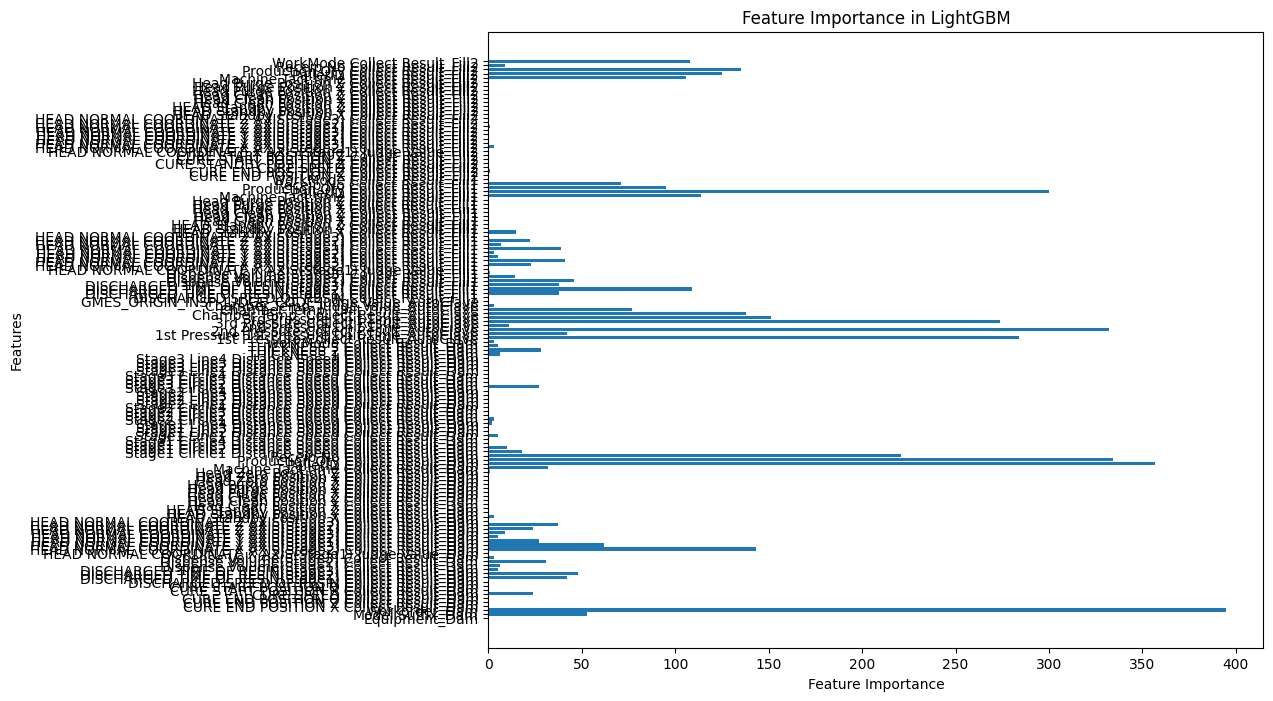

In [189]:
# 피처 중요도 추출
import matplotlib.pyplot as plt
import lightgbm as lgb

# 피처 중요도 확인
importance = lgb_model.feature_importance()
feature_names = X_train.columns

# 중요도 시각화
plt.figure(figsize=(10, 8))
plt.barh(feature_names, importance)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in LightGBM")
plt.show()

In [190]:
# # 특성 중요도를 데이터프레임으로 변환
# importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})

# # 중요도 순으로 정렬
# importance_df = importance_df.sort_values(by='Importance', ascending=False)

# # 임계값을 설정하여 중요도가 낮은 특성 제거 (예: 중요도가 0인 경우)
# threshold = 0
# low_importance_features = importance_df[importance_df['Importance'] <= threshold]['Feature']

# low_importance_features

# # 중요도가 0인 특성을 제외한 데이터셋 생성
# X_train_reduced = X_train.drop(columns=low_importance_features)
# X_val_reduced = X_valid.drop(columns=low_importance_features)

# print(X_train_reduced)

### 모델 정의(RandomForestClassifier)

In [191]:
#model = RandomForestClassifier(random_state=RANDOM_STATE)

In [192]:
# features = []

# for col in df_train.columns:
#     try:
#         df_train[col] = df_train[col].astype(int)
#         features.append(col)
#     except:
#         continue

# train_x = df_train[features]
# train_y = df_train["target"]

# model.fit(train_x, train_y)

In [193]:
# from sklearn.linear_model import LogisticRegression
# # 로지스틱 회귀 모델 초기화
# logistic_model = LogisticRegression(random_state=RANDOM_STATE)

# # 모델 학습
# logistic_model.fit(X_train, y_train)

# # 검증 데이터 예측
# y_pred = logistic_model.predict(X_val)

# # F1-score 및 분류 리포트 출력
# f1 = f1_score(y_val, y_pred, pos_label='AbNormal')
# print(f"F1 Score: {f1}")
# print(classification_report(y_val, y_pred, target_names=['Normal', 'AbNormal']))

### 모델 학습


In [194]:
# model.fit(X_train_pca, y_train)

# # 검증 데이터 예측
# val_pred = model.predict(X_val_pca)

# # 결과 확인 (추가적인 평가 지표를 사용하여 성능 평가 가능)
# from sklearn.metrics import classification_report
# print(classification_report(y_val, val_pred))

## 4. 제출하기


### 테스트 데이터 예측


테스트 데이터 불러오기


In [195]:
# test.csv 파일 불러오기
test_data = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))

# 훈련 데이터에서 사용된 컬럼 리스트 가져오기
train_columns = df_train.columns.tolist()
# 중요도가 0인 특성을 제외한 데이터셋 생성
# train_columns = train_columns.drop(columns=low_importance_features)
train_columns.remove('target')

# 테스트 데이터에서 훈련 데이터의 컬럼들만 선택
df_test_x = test_data[train_columns]

# # 'OK' 컬럼 전처리
# okok_columns = df_test_x.columns[df_test_x.isin(['OK']).any()]
# df_test_x.loc[:, okok_columns] = df_test_x.loc[:, okok_columns].apply(lambda col: col.map(lambda x: 1 if x == 'OK' else 0))

# # equipment_dam 전처리
# df_test_x.loc[:, 'Equipment_Dam'] = df_test_x['Equipment_Dam'].apply(convert_value)

# # medel.suffix 와 workorder 전처리
# columns_to_encode = ['Model.Suffix_Dam', 'Workorder_Dam']

# # 각 컬럼에 대해 레이블 인코딩 수행
# for col in columns_to_encode:
#     df_test_x.loc[:, col] = label_encoder.fit_transform(df_test_x[col])
  

In [196]:
columns_to_transform = ['HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam',
                        'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave',
                        'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1',
                        'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2']

# 변환: null 값이 있는 열은 0, 'OK' 값이 있는 열은 1로
df_test_x[columns_to_transform] = df_test_x[columns_to_transform].applymap(lambda x: 1 if x == 'OK' else 0)

columns_to_transform = ['Chamber Temp. Judge Value_AutoClave']
 
# 변환: NG 값은 0, 'OK' 값은 1로
df_test_x[columns_to_transform] = df_test_x[columns_to_transform].applymap(lambda x: 1 if x == 'OK' else 0)

# 레이블 인코딩할 컬럼들의 이름 리스트
columns_to_encode = ['Model.Suffix_Dam', 'Workorder_Dam']  # 예시 컬럼들

# 각 컬럼에 대해 레이블 인코딩 수행
label_encoder = LabelEncoder()
for col in columns_to_encode:
    df_test_x[col] = label_encoder.fit_transform(df_test_x[col])
    
# Equipment_Dam 컬럼의 앞뒤 공백 제거
df_test_x['Equipment_Dam'] = df_test_x['Equipment_Dam'].str.strip()

# Equipment_Dam 컬럼의 값을 숫자로 변환
df_test_x['Equipment_Dam'] = df_test_x['Equipment_Dam'].map({
    'Dam dispenser #1': 1,
    'Dam dispenser #2': 2
})


/tmp/ipykernel_55/1081184652.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_test_x[columns_to_transform] = df_test_x[columns_to_transform].applymap(lambda x: 1 if x == 'OK' else 0)
/tmp/ipykernel_55/1081184652.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_x[columns_to_transform] = df_test_x[columns_to_transform].applymap(lambda x: 1 if x == 'OK' else 0)
/tmp/ipykernel_55/1081184652.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_test_x[columns_to_transform] = df_test_x[columns_to_transform].applymap(lambda x: 1 if x == 'OK' else 0)
/tmp/ipykernel_55/1081184652.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [197]:
# 모델 예측
test_pred = lgb_model.predict(df_test_x)
test_pred

array([0.62157346, 0.57083262, 0.43910942, ..., 0.55960422, 0.39216337,
       0.60060432])

In [198]:
# # 훈련 데이터에서의 스케일러와 PCA 모델을 사용하여 변환 적용
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)  # 훈련 시 사용한 스케일러 적용
# pca = PCA(n_components=0.8)
# pca.fit(X_train_scaled)  # 훈련 시 사용한 PCA 피팅

# # 테스트 데이터 스케일링 및 PCA 적용
# X_test_scaled = scaler.transform(df_test_x)
# X_test_pca = pca.transform(X_test_scaled)

# # 모델 예측
# test_pred = model.predict(X_test_pca)
# test_pred

In [199]:
# test_data = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))

In [200]:
# df_test_x = test_data[features]

# for col in df_test_x.columns:
#     try:
#         df_test_x.loc[:, col] = df_test_x[col].astype(int)
#     except:
#         continue

In [201]:
# # 'OK' 컬럼 전처리
# okok_columns = df_test_x.columns[df_test_x.isin(['OK']).any()]
# df_test_x.loc[:, okok_columns] = df_test_x[okok_columns].apply(lambda col: col.map(lambda x: 1 if x == 'OK' else 0))

# # equipment_dam 전처리
# df_test_x['Equipment_Dam'] = df_test_x['Equipment_Dam'].apply(convert_value)

# # medel.suffix 와 workorder 전처리
# columns_to_encode = ['Model.Suffix_Dam', 'Workorder_Dam']

# # 각 컬럼에 대해 레이블 인코딩 수행
# for col in columns_to_encode:
#     df_test_x[col] = label_encoder.fit_transform(df_test_x[col])

In [202]:
# test_pred = model.predict(df_test_x)
# test_pred

### 제출 파일 작성


In [203]:
# # 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
# df_sub = pd.read_csv("submission.csv")
# df_sub["target"] = test_pred

# # 제출 파일 저장
# df_sub.to_csv("submission.csv", index=False)

In [204]:
# 제출 데이터 읽어오기 (df_test_x는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")

# 확률값을 0과 1로 변환
df_sub["target"] = ['Normal'if pred > 0.35 else 'AbNormal' for pred in test_pred]

print(df_sub)

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

                                 Set ID  target
0      0001be084fbc4aaa9d921f39e595961b  Normal
1      0005bbd180064abd99e63f9ed3e1ac80  Normal
2      000948934c4140d883d670adcb609584  Normal
3      000a6bfd02874c6296dc7b2e9c5678a7  Normal
4      0018e78ce91343678716e2ea27a51c95  Normal
...                                 ...     ...
17356  ffea508b59934d689b540f95eb3fa730  Normal
17357  ffed8923c8a448a98afc641b770be153  Normal
17358  fff1e73734da40adbe805359b3efb462  Normal
17359  fff8e38bdd09470baf95f71e92075dec  Normal
17360  fffa83e0a13d4c2db4fd8bf905b517d4  Normal

[17361 rows x 2 columns]


**우측 상단의 제출 버튼을 클릭해 결과를 확인하세요**
